In [16]:
import os
import sys
import math

import torch
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('..')
from analysis.load_results import *
from analysis.plots import *

## Load Results

In [2]:
experiment_info = {
    'results_dir': os.getenv('RESULTS_DIR'),
    'experiment_name': 'counterfact_probing',
    'dataset_name': 'counterfact.pyth.64.-1',
    'inner_loop': 'heuristic_sparsity_sweep',
}
model_sizes = ['70m', '160m', '410m', '1b', '2.8b']
all_results = []
for s in model_sizes:
    results_dict = load_probing_experiment_results(**experiment_info, model_name=f'pythia-{s}')

    flattened_results = {}
    for (feature, layer, aggregation, hook_loc), value in results_dict.items():
        for k in value.keys():
            flattened_results[(feature, layer, k)] = value[k]
    rdf = pd.DataFrame(flattened_results).T.rename_axis(index=['feature', 'layer', 'k']).sort_index()
    rdf.index = pd.MultiIndex.from_tuples(
        [(s, *i) for i in rdf.index.values],
        names=['model_size', 'feature', 'layer', 'k'])

    all_results.append(rdf)
rdf = pd.concat(all_results)
rdf.shape

(1634, 18)

In [3]:
# get top test_pr_auc for each model
n_per_model = 3
cols = ['test_pr_auc', 'test_precision', 'test_recall', 'test_acc']
all_pr_auc = []
for s in model_sizes:
    model_rdf = rdf.query(f'model_size=="{s}"').sort_values('test_pr_auc', ascending=False).head(n_per_model)[cols]
    all_pr_auc.append(model_rdf)
pd.concat(all_pr_auc)

test_pr_auc test_precision test_recall  \
model_size feature   layer k                                              
70m        text_true 3     2048     0.727971       0.651577    0.631372   
                     4     2048      0.72791       0.651684    0.629406   
                           1024     0.727268       0.652441    0.626683   
160m       text_true 7     3072     0.778465       0.695725    0.689306   
                           2048     0.778449       0.692777    0.687642   
                           1024     0.774827       0.687614    0.681894   
410m       text_true 11    2048     0.808965        0.70889    0.706852   
                           4096     0.808961       0.708459    0.709424   
                     10    4096     0.807883       0.711398    0.708062   
1b         text_true 9     2048     0.844867       0.749393    0.746786   
                     7     8192     0.844151       0.747749    0.741189   
                           2048     0.842747       0.747583    0.736954   
2.8b       text_true 16    10240    0.879551       0.781274     0.77371   
                           8192      0.87905       0.781522    0.775374   
                     10    10240    0.878373       0.783028    0.774618   

                                  test_acc  
model_size feature   layer k                
70m        text_true 3     2048   0.644997  
                     4     2048   0.644617  
                           1024   0.644541  
160m       text_true 7     3072    0.69229  
                           2048   0.689705  
                           1024   0.684383  
410m       text_true 11    2048   0.706737  
                           4096   0.707193  
                     10    4096   0.708866  
1b         text_true 9     2048   0.747187  
                     7     8192   0.744221  
                           2048   0.742701  
2.8b       text_true 16    10240  0.777372  
                           8192   0.778133  
                     10    10240  0.778817

In [4]:
# test_pr_auc for k=1
n_per_model = 3
cols = ['test_pr_auc', 'test_precision', 'test_recall', 'test_acc']
all_pr_auc = []
for s in model_sizes:
    model_rdf = rdf.query(f'model_size=="{s}" and k==1').sort_values('test_pr_auc', ascending=False).head(n_per_model)[cols]
    all_pr_auc.append(model_rdf)
pd.concat(all_pr_auc)

test_pr_auc test_precision test_recall  test_acc
model_size feature   layer k                                                 
70m        text_true 1     1    0.620682        0.64078    0.283316  0.559915
                     4     1    0.560473       0.536815    0.345182  0.521137
                     2     1    0.520669       0.502037    0.503403  0.499392
160m       text_true 4     1     0.61638        0.62963    0.298291  0.559078
                     2     1    0.606014       0.613929    0.245349  0.543111
                     6     1    0.566522       0.551284    0.509756  0.545012
410m       text_true 3     1    0.564942       0.540889      0.4252  0.529653
                     4     1    0.554033       0.544062    0.413704  0.531022
                     23    1    0.540244       0.525099    0.560127  0.524255
1b         text_true 1     1    0.558611       0.550051    0.243534  0.519617
                     10    1    0.519311       0.520408    0.509151  0.517412
                     12    1    0.517487       0.516019    0.501891  0.513002
2.8b       text_true 3     1    0.618416       0.664279    0.224474  0.553148
                     4     1     0.57936       0.531345    0.369233  0.519237
                     5     1    0.577244       0.571663    0.421116  0.550411

## Sparsity Curves

In [51]:
def colorFader(c1='red', c2='blue', mix=0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

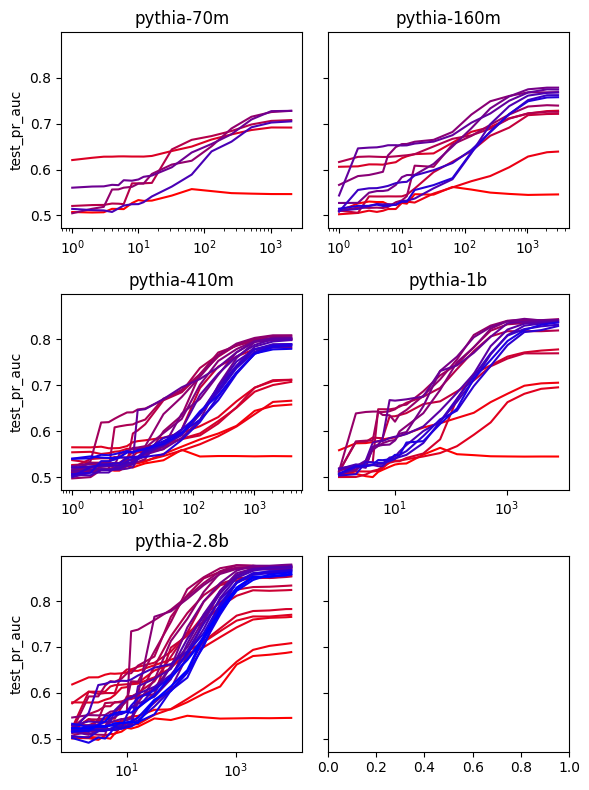

In [55]:
metric = 'test_pr_auc'
feature = 'text_true'
n_cols = 2

n_rows = math.ceil(len(model_sizes) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 4*(len(model_sizes)//2)), sharey=True)

for i, (s, ax) in enumerate(zip(model_sizes, axes.flatten())):
    model_rdf = rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True)
    layers = sorted(model_rdf.index.get_level_values(1).unique())
    ks = sorted(model_rdf.index.get_level_values(2).unique())

    for l in layers:
        perf = model_rdf.loc[feature, l, ks][metric].values
        ax.plot(ks, perf, label=l, color=colorFader(mix=l/(len(layers)+1)))
    
    ax.set_xscale('log')
    ax.set_title(f'pythia-{s}')

    if i % n_cols == 0:
        ax.set_ylabel(metric)

fig.tight_layout()